# Regression using Pytorch

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from source.ffnn_model import WellLogFFNN
from source.ffnn_well_data_preprocessing import load_log_data

# Reproducibility, gotten from project 2
NP_RANDOM_SEED = 42
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)


In [2]:
(X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

print("Shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:",   X_val.shape)
print("X_test:",  X_test.shape)



[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Shapes:
X_train: torch.Size([8699, 11])
y_train: torch.Size([8699, 1])
X_val: torch.Size([1864, 11])
X_test: torch.Size([1865, 11])


In [3]:
# Basic statistics of y_train
print("y_train min:", y_train.min().item())
print("y_train max:", y_train.max().item())
print("y_train mean:", y_train.mean().item())
print("y_train std:", y_train.std().item())


y_train min: -4.86965799331665
y_train max: 3.1156673431396484
y_train mean: 1.7540854324593624e-09
y_train std: 1.0000574588775635


In [4]:
"""

Defining model and training function.

The model is a feedforward neural network defined in source/ffnn_model.py.

The training function uses MSE loss and Adam optimizer.

Code is adapted from project 2 part c.

"""

input_dim = X_train.shape[1]

# Defining model
def make_model(hidden_dims=(64, 64), dropout=0.2, activation=nn.ReLU):
    return WellLogFFNN(
        input_dim=input_dim,
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    )
# Training function
def train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr: float = 1e-3,
    epochs: int = 100,
    verbose: bool = False,
):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float("inf")
    best_state_dict = None

    train_losses = []
    val_losses   = []

    for epoch in range(epochs):
        # ---- TRAIN ----
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # ---- VALIDATION ----
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state_dict = model.state_dict()

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:4d} | Train MSE: {loss.item():.4f} | Val MSE: {val_loss:.4f}")

    # last best weights
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    return model, best_val_loss, train_losses, val_losses


In [5]:
# Training with different configurations and evaluating on test set
configs = [
    {"name": "small_no_dropout",  "hidden_dims": (32, 32),        "lr": 1e-3, "dropout": 0.0},
    {"name": "medium_dropout",    "hidden_dims": (64, 64),        "lr": 1e-3, "dropout": 0.2},
    {"name": "deep_dropout",      "hidden_dims": (128, 64, 32),   "lr": 1e-4, "dropout": 0.2},
    {"name": "medium_lr_high",    "hidden_dims": (64, 64),        "lr": 1e-2, "dropout": 0.2},
]

results = []
histories = {}

for cfg in configs:
    print(f"\n=== Training config: {cfg['name']} ===")
    print(f"hidden_dims={cfg['hidden_dims']}, lr={cfg['lr']}, dropout={cfg['dropout']}")

    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)

    model = make_model(
        hidden_dims=cfg["hidden_dims"],
        dropout=cfg["dropout"],
        activation=nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=cfg["lr"],
        epochs=100,
        verbose=False,
    )

    # evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)
        test_mse = nn.MSELoss()(y_pred_test, y_test).item()

    results.append({
        "name":        cfg["name"],
        "hidden_dims": cfg["hidden_dims"],
        "lr":          cfg["lr"],
        "dropout":     cfg["dropout"],
        "val_mse":     best_val_mse,
        "test_mse":    test_mse,
    })

    histories[cfg["name"]] = {
        "train_losses": train_losses,
        "val_losses":   val_losses,
    }

results_df = pd.DataFrame(results)
display(results_df)



=== Training config: small_no_dropout ===
hidden_dims=(32, 32), lr=0.001, dropout=0.0



=== Training config: medium_dropout ===
hidden_dims=(64, 64), lr=0.001, dropout=0.2

=== Training config: deep_dropout ===
hidden_dims=(128, 64, 32), lr=0.0001, dropout=0.2

=== Training config: medium_lr_high ===
hidden_dims=(64, 64), lr=0.01, dropout=0.2


,name,hidden_dims,lr,dropout,val_mse,test_mse
0,small_no_dropout,"(32, 32)",0.0010,0.0,0.297210,0.292546
1,medium_dropout,"(64, 64)",0.0010,0.2,0.258608,0.258091
2,deep_dropout,"(128, 64, 32)",0.0001,0.2,0.776391,0.753126
3,medium_lr_high,"(64, 64)",0.0100,0.2,0.194830,0.190558


In [6]:
import optuna
from optuna.trial import Trial  

"""Objective function for Optuna hyperparameter optimization."""

# Define objective function for Optuna
def objective(trial):
    data_seed = trial.suggest_int("data_seed", 0, 1_000_000)

    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(
        random_state=data_seed
    )    
    
    
    # Suggest hyperparameters
    hidden_dim1 = trial.suggest_int("hidden_dim1", 16, 256, step=16)
    hidden_dim2 = trial.suggest_int("hidden_dim2", 16, 256, step=16)
    hidden_dim3 = trial.suggest_int("hidden_dim3", 16, 256, step=16)
    n_layers = trial.suggest_int("n_layers", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.5, step=0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    
    # Build hidden_dims tuple based on n_layers
    hidden_dims_list = [hidden_dim1, hidden_dim2, hidden_dim3][:n_layers]
    hidden_dims = tuple(hidden_dims_list)
    
    # Reset seeds for reproducibility
    torch.manual_seed(NP_RANDOM_SEED)
    np.random.seed(NP_RANDOM_SEED)
    
    # Create and train model
    model = make_model(
        hidden_dims=hidden_dims,
        dropout=dropout, 
        activation=nn.ReLU,
    )
    
    model, best_val_mse, _, _ = train_model(
        model,
        X_train, y_train,
        X_val, y_val,
        lr=lr,
        epochs=100,
        verbose=False,
    )
    
    return best_val_mse

# Create and run Optuna study
print("Starting Optuna hyperparameter optimization...")
study = optuna.create_study(
    study_name="ffnn_regression_study",
    storage="sqlite:///optuna_study.db",
    direction="minimize",
    load_if_exists=True,
)

study.optimize(objective, n_trials=50, show_progress_bar=True)

# Get best trial
best_trial = study.best_trial

print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"Best validation MSE: {best_trial.value:.6f}")
print("\nBest hyperparameters:")
for key, value in best_trial.params.items():
    print(f"  {key}: {value}")
print("="*60)


/workspaces/project3/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Optuna hyperparameter optimization...


[I 2025-12-16 12:59:23,183] Using an existing study with name 'ffnn_regression_study' instead of creating a new one.
  0%|          | 0/50 [00:00<?, ?it/s]

[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 0. Best value: 0.905755:   2%|▏         | 1/50 [00:01<01:36,  1.97s/it]

[I 2025-12-16 12:59:25,148] Trial 0 finished with value: 0.9057552814483643 and parameters: {'data_seed': 145051, 'hidden_dim1': 80, 'hidden_dim2': 128, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 1.440067253687012e-05}. Best is trial 0 with value: 0.9057552814483643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 1. Best value: 0.233572:   4%|▍         | 2/50 [00:04<01:59,  2.49s/it]

[I 2025-12-16 12:59:28,003] Trial 1 finished with value: 0.23357214033603668 and parameters: {'data_seed': 663140, 'hidden_dim1': 48, 'hidden_dim2': 224, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.00042022564721036135}. Best is trial 1 with value: 0.23357214033603668.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:   6%|▌         | 3/50 [00:16<05:09,  6.58s/it]

[I 2025-12-16 12:59:39,447] Trial 2 finished with value: 0.19459164142608643 and parameters: {'data_seed': 936854, 'hidden_dim1': 112, 'hidden_dim2': 192, 'hidden_dim3': 128, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.004649864423156005}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:   8%|▊         | 4/50 [00:21<04:41,  6.13s/it]

[I 2025-12-16 12:59:44,890] Trial 3 finished with value: 0.9994205832481384 and parameters: {'data_seed': 606152, 'hidden_dim1': 96, 'hidden_dim2': 160, 'hidden_dim3': 16, 'n_layers': 4, 'dropout': 0.1, 'lr': 1.289714559975521e-05}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:  10%|█         | 5/50 [00:38<07:31, 10.03s/it]

[I 2025-12-16 13:00:01,832] Trial 4 finished with value: 1.0028363466262817 and parameters: {'data_seed': 3282, 'hidden_dim1': 176, 'hidden_dim2': 224, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.5, 'lr': 1.0100539592519856e-05}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:  12%|█▏        | 6/50 [00:41<05:27,  7.45s/it]

[I 2025-12-16 13:00:04,264] Trial 5 finished with value: 0.2817506492137909 and parameters: {'data_seed': 303036, 'hidden_dim1': 144, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.00022743033326474377}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:  14%|█▍        | 7/50 [00:44<04:24,  6.14s/it]

[I 2025-12-16 13:00:07,729] Trial 6 finished with value: 0.7477335929870605 and parameters: {'data_seed': 821898, 'hidden_dim1': 48, 'hidden_dim2': 144, 'hidden_dim3': 224, 'n_layers': 2, 'dropout': 0.30000000000000004, 'lr': 7.296533908476717e-05}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:  16%|█▌        | 8/50 [00:53<04:52,  6.97s/it]

[I 2025-12-16 13:00:16,472] Trial 7 finished with value: 0.7397112250328064 and parameters: {'data_seed': 651425, 'hidden_dim1': 176, 'hidden_dim2': 240, 'hidden_dim3': 96, 'n_layers': 2, 'dropout': 0.4, 'lr': 3.418883868019029e-05}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 2. Best value: 0.194592:  18%|█▊        | 9/50 [01:02<05:10,  7.57s/it]

[I 2025-12-16 13:00:25,368] Trial 8 finished with value: 0.23910798132419586 and parameters: {'data_seed': 584175, 'hidden_dim1': 112, 'hidden_dim2': 160, 'hidden_dim3': 240, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.0002945633401548464}. Best is trial 2 with value: 0.19459164142608643.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  20%|██        | 10/50 [01:04<04:00,  6.02s/it]

[I 2025-12-16 13:00:27,905] Trial 9 finished with value: 0.16305403411388397 and parameters: {'data_seed': 646700, 'hidden_dim1': 48, 'hidden_dim2': 128, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.0, 'lr': 0.0071532634588634845}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  22%|██▏       | 11/50 [01:08<03:29,  5.36s/it]

[I 2025-12-16 13:00:31,771] Trial 10 finished with value: 0.2178419530391693 and parameters: {'data_seed': 353383, 'hidden_dim1': 16, 'hidden_dim2': 32, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.005003047437128729}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  24%|██▍       | 12/50 [01:16<03:56,  6.23s/it]

[I 2025-12-16 13:00:40,010] Trial 11 finished with value: 0.17230474948883057 and parameters: {'data_seed': 941259, 'hidden_dim1': 224, 'hidden_dim2': 80, 'hidden_dim3': 112, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.009306154961459312}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  26%|██▌       | 13/50 [01:24<04:10,  6.77s/it]

[I 2025-12-16 13:00:48,003] Trial 12 finished with value: 0.19080829620361328 and parameters: {'data_seed': 978768, 'hidden_dim1': 256, 'hidden_dim2': 80, 'hidden_dim3': 96, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.009569221817161262}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  28%|██▊       | 14/50 [01:35<04:44,  7.91s/it]

[I 2025-12-16 13:00:58,537] Trial 13 finished with value: 0.21338798105716705 and parameters: {'data_seed': 716336, 'hidden_dim1': 240, 'hidden_dim2': 96, 'hidden_dim3': 160, 'n_layers': 4, 'dropout': 0.5, 'lr': 0.0016153121352341273}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  30%|███       | 15/50 [01:40<04:05,  7.03s/it]

[I 2025-12-16 13:01:03,528] Trial 14 finished with value: 0.20234942436218262 and parameters: {'data_seed': 825684, 'hidden_dim1': 208, 'hidden_dim2': 32, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0015884958471867904}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 9. Best value: 0.163054:  32%|███▏      | 16/50 [01:49<04:18,  7.60s/it]

[I 2025-12-16 13:01:12,455] Trial 15 finished with value: 0.19890709221363068 and parameters: {'data_seed': 435534, 'hidden_dim1': 160, 'hidden_dim2': 80, 'hidden_dim3': 192, 'n_layers': 4, 'dropout': 0.4, 'lr': 0.001625971955590428}. Best is trial 9 with value: 0.16305403411388397.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.146986:  34%|███▍      | 17/50 [01:56<04:10,  7.59s/it]

[I 2025-12-16 13:01:20,029] Trial 16 finished with value: 0.14698641002178192 and parameters: {'data_seed': 820167, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.009846812375113801}. Best is trial 16 with value: 0.14698641002178192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.146986:  36%|███▌      | 18/50 [02:05<04:13,  7.92s/it]

[I 2025-12-16 13:01:28,729] Trial 17 finished with value: 0.15085621178150177 and parameters: {'data_seed': 789495, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.002961309575941223}. Best is trial 16 with value: 0.14698641002178192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.146986:  38%|███▊      | 19/50 [02:13<04:07,  7.99s/it]

[I 2025-12-16 13:01:36,858] Trial 18 finished with value: 0.16196268796920776 and parameters: {'data_seed': 805849, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.002734720829403144}. Best is trial 16 with value: 0.14698641002178192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.146986:  40%|████      | 20/50 [02:19<03:38,  7.27s/it]

[I 2025-12-16 13:01:42,451] Trial 19 finished with value: 0.21716584265232086 and parameters: {'data_seed': 494793, 'hidden_dim1': 192, 'hidden_dim2': 64, 'hidden_dim3': 64, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0007565399343664707}. Best is trial 16 with value: 0.14698641002178192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 16. Best value: 0.146986:  42%|████▏     | 21/50 [02:27<03:35,  7.42s/it]

[I 2025-12-16 13:01:50,238] Trial 20 finished with value: 0.16688229143619537 and parameters: {'data_seed': 754577, 'hidden_dim1': 256, 'hidden_dim2': 48, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.003363114222491701}. Best is trial 16 with value: 0.14698641002178192.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  44%|████▍     | 22/50 [02:34<03:31,  7.56s/it]

[I 2025-12-16 13:01:58,111] Trial 21 finished with value: 0.14649154245853424 and parameters: {'data_seed': 838744, 'hidden_dim1': 208, 'hidden_dim2': 112, 'hidden_dim3': 160, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0024672740960385415}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  46%|████▌     | 23/50 [02:42<03:25,  7.62s/it]

[I 2025-12-16 13:02:05,870] Trial 22 finished with value: 0.2129063457250595 and parameters: {'data_seed': 833399, 'hidden_dim1': 224, 'hidden_dim2': 112, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0008928777221538552}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  48%|████▊     | 24/50 [02:52<03:34,  8.25s/it]

[I 2025-12-16 13:02:15,594] Trial 23 finished with value: 0.15334606170654297 and parameters: {'data_seed': 901104, 'hidden_dim1': 192, 'hidden_dim2': 160, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.0025735609957358418}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  50%|█████     | 25/50 [02:58<03:09,  7.60s/it]

[I 2025-12-16 13:02:21,666] Trial 24 finished with value: 0.19862422347068787 and parameters: {'data_seed': 881563, 'hidden_dim1': 144, 'hidden_dim2': 112, 'hidden_dim3': 128, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0007561416371963348}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  52%|█████▏    | 26/50 [03:01<02:30,  6.26s/it]

[I 2025-12-16 13:02:24,802] Trial 25 finished with value: 0.1559334248304367 and parameters: {'data_seed': 736680, 'hidden_dim1': 224, 'hidden_dim2': 96, 'hidden_dim3': 144, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.005498200689492687}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 21. Best value: 0.146492:  54%|█████▍    | 27/50 [03:07<02:20,  6.09s/it]

[I 2025-12-16 13:02:30,502] Trial 26 finished with value: 0.3791135251522064 and parameters: {'data_seed': 994823, 'hidden_dim1': 176, 'hidden_dim2': 144, 'hidden_dim3': 80, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.00010203490600837174}. Best is trial 21 with value: 0.14649154245853424.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 27. Best value: 0.140225:  56%|█████▌    | 28/50 [03:18<02:47,  7.63s/it]

[I 2025-12-16 13:02:41,737] Trial 27 finished with value: 0.14022518694400787 and parameters: {'data_seed': 536718, 'hidden_dim1': 240, 'hidden_dim2': 192, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0031171527662924516}. Best is trial 27 with value: 0.14022518694400787.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 27. Best value: 0.140225:  58%|█████▊    | 29/50 [03:26<02:40,  7.65s/it]

[I 2025-12-16 13:02:49,441] Trial 28 finished with value: 0.21070443093776703 and parameters: {'data_seed': 519148, 'hidden_dim1': 240, 'hidden_dim2': 192, 'hidden_dim3': 112, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.0011512479115805645}. Best is trial 27 with value: 0.14022518694400787.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 27. Best value: 0.140225:  60%|██████    | 30/50 [03:29<02:09,  6.46s/it]

[I 2025-12-16 13:02:53,102] Trial 29 finished with value: 0.1524476408958435 and parameters: {'data_seed': 261175, 'hidden_dim1': 256, 'hidden_dim2': 176, 'hidden_dim3': 160, 'n_layers': 2, 'dropout': 0.0, 'lr': 0.004073143141750502}. Best is trial 27 with value: 0.14022518694400787.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 27. Best value: 0.140225:  62%|██████▏   | 31/50 [03:43<02:44,  8.65s/it]

[I 2025-12-16 13:03:06,877] Trial 30 finished with value: 0.2320081740617752 and parameters: {'data_seed': 224613, 'hidden_dim1': 240, 'hidden_dim2': 208, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.0004058708111002168}. Best is trial 27 with value: 0.14022518694400787.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  64%|██████▍   | 32/50 [03:58<03:07, 10.39s/it]

[I 2025-12-16 13:03:21,317] Trial 31 finished with value: 0.14006666839122772 and parameters: {'data_seed': 746546, 'hidden_dim1': 208, 'hidden_dim2': 256, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0023076741086409283}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  66%|██████▌   | 33/50 [04:04<02:35,  9.16s/it]

[I 2025-12-16 13:03:27,604] Trial 32 finished with value: 0.14428016543388367 and parameters: {'data_seed': 698845, 'hidden_dim1': 192, 'hidden_dim2': 256, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0024097049478643507}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  68%|██████▊   | 34/50 [04:11<02:14,  8.39s/it]

[I 2025-12-16 13:03:34,187] Trial 33 finished with value: 0.15631785988807678 and parameters: {'data_seed': 549948, 'hidden_dim1': 192, 'hidden_dim2': 256, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0022094222743608005}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  70%|███████   | 35/50 [04:17<01:55,  7.68s/it]

[I 2025-12-16 13:03:40,209] Trial 34 finished with value: 0.1998385190963745 and parameters: {'data_seed': 716127, 'hidden_dim1': 160, 'hidden_dim2': 256, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.000505287575383545}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  72%|███████▏  | 36/50 [04:22<01:38,  7.06s/it]

[I 2025-12-16 13:03:45,843] Trial 35 finished with value: 0.1766272634267807 and parameters: {'data_seed': 452856, 'hidden_dim1': 224, 'hidden_dim2': 224, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0015131208396619263}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 31. Best value: 0.140067:  74%|███████▍  | 37/50 [04:28<01:28,  6.82s/it]

[I 2025-12-16 13:03:52,093] Trial 36 finished with value: 0.2555508613586426 and parameters: {'data_seed': 692018, 'hidden_dim1': 160, 'hidden_dim2': 240, 'hidden_dim3': 256, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0001818498297841318}. Best is trial 31 with value: 0.14006666839122772.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  76%|███████▌  | 38/50 [04:39<01:34,  7.89s/it]

[I 2025-12-16 13:04:02,484] Trial 37 finished with value: 0.1350753754377365 and parameters: {'data_seed': 611721, 'hidden_dim1': 128, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0020594557496893835}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  78%|███████▊  | 39/50 [04:44<01:17,  7.09s/it]

[I 2025-12-16 13:04:07,704] Trial 38 finished with value: 0.15380100905895233 and parameters: {'data_seed': 603332, 'hidden_dim1': 96, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 2, 'dropout': 0.2, 'lr': 0.005959426605524639}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  80%|████████  | 40/50 [04:50<01:06,  6.62s/it]

[I 2025-12-16 13:04:13,222] Trial 39 finished with value: 0.16053026914596558 and parameters: {'data_seed': 378220, 'hidden_dim1': 128, 'hidden_dim2': 240, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.0010781402463354768}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  82%|████████▏ | 41/50 [04:59<01:06,  7.42s/it]

[I 2025-12-16 13:04:22,525] Trial 40 finished with value: 0.1523647904396057 and parameters: {'data_seed': 645099, 'hidden_dim1': 80, 'hidden_dim2': 208, 'hidden_dim3': 208, 'n_layers': 4, 'dropout': 0.1, 'lr': 0.004025352119250574}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  84%|████████▍ | 42/50 [05:11<01:10,  8.75s/it]

[I 2025-12-16 13:04:34,382] Trial 41 finished with value: 0.1954597681760788 and parameters: {'data_seed': 568909, 'hidden_dim1': 176, 'hidden_dim2': 224, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.000568373097846695}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  86%|████████▌ | 43/50 [05:23<01:08,  9.74s/it]

[I 2025-12-16 13:04:46,410] Trial 42 finished with value: 0.16325654089450836 and parameters: {'data_seed': 47112, 'hidden_dim1': 128, 'hidden_dim2': 256, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.002072333254952188}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  88%|████████▊ | 44/50 [05:32<00:57,  9.55s/it]

[I 2025-12-16 13:04:55,530] Trial 43 finished with value: 0.1691220998764038 and parameters: {'data_seed': 651123, 'hidden_dim1': 112, 'hidden_dim2': 176, 'hidden_dim3': 176, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.003255489671614949}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  90%|█████████ | 45/50 [05:46<00:54, 10.80s/it]

[I 2025-12-16 13:05:09,259] Trial 44 finished with value: 0.16607053577899933 and parameters: {'data_seed': 768329, 'hidden_dim1': 192, 'hidden_dim2': 240, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.006611732455082333}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  92%|█████████▏| 46/50 [05:50<00:35,  8.87s/it]

[I 2025-12-16 13:05:13,601] Trial 45 finished with value: 0.19064640998840332 and parameters: {'data_seed': 675207, 'hidden_dim1': 144, 'hidden_dim2': 176, 'hidden_dim3': 192, 'n_layers': 3, 'dropout': 0.0, 'lr': 0.001173148380939433}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  94%|█████████▍| 47/50 [06:04<00:30, 10.29s/it]

[I 2025-12-16 13:05:27,211] Trial 46 finished with value: 0.166080504655838 and parameters: {'data_seed': 871881, 'hidden_dim1': 240, 'hidden_dim2': 192, 'hidden_dim3': 240, 'n_layers': 3, 'dropout': 0.2, 'lr': 0.002060498624766984}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  96%|█████████▌| 48/50 [06:18<00:23, 11.59s/it]

[I 2025-12-16 13:05:41,820] Trial 47 finished with value: 0.17095619440078735 and parameters: {'data_seed': 630930, 'hidden_dim1': 224, 'hidden_dim2': 224, 'hidden_dim3': 208, 'n_layers': 3, 'dropout': 0.30000000000000004, 'lr': 0.0040665397275376994}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075:  98%|█████████▊| 49/50 [06:22<00:09,  9.33s/it]

[I 2025-12-16 13:05:45,888] Trial 48 finished with value: 0.8866514563560486 and parameters: {'data_seed': 522106, 'hidden_dim1': 96, 'hidden_dim2': 240, 'hidden_dim3': 144, 'n_layers': 4, 'dropout': 0.0, 'lr': 1.8148902630264586e-05}. Best is trial 37 with value: 0.1350753754377365.
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)


Best trial: 37. Best value: 0.135075: 100%|██████████| 50/50 [06:31<00:00,  7.82s/it]

[I 2025-12-16 13:05:54,352] Trial 49 finished with value: 0.17878015339374542 and parameters: {'data_seed': 460502, 'hidden_dim1': 208, 'hidden_dim2': 256, 'hidden_dim3': 256, 'n_layers': 2, 'dropout': 0.1, 'lr': 0.0016770572503241332}. Best is trial 37 with value: 0.1350753754377365.

OPTUNA OPTIMIZATION RESULTS
Best validation MSE: 0.135075

Best hyperparameters:
  data_seed: 611721
  hidden_dim1: 128
  hidden_dim2: 208
  hidden_dim3: 224
  n_layers: 3
  dropout: 0.1
  lr: 0.0020594557496893835


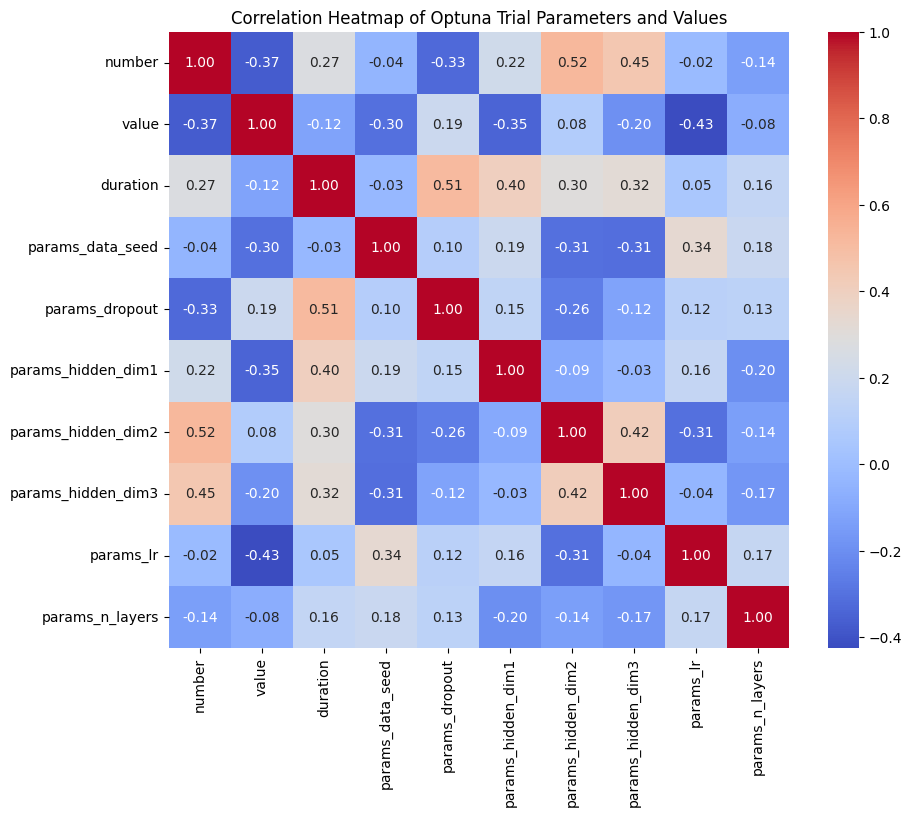

In [7]:
#plotting a heatmap of the optuna results
import seaborn as sns
import matplotlib.pyplot as plt

optuna_df = study.trials_dataframe()
plt.figure(figsize=(10, 8))
sns.heatmap(optuna_df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Optuna Trial Parameters and Values")
plt.show()

In [8]:
# === Extract best hyperparameters from Optuna ===
best_params = best_trial.params

# Build hidden layers tuple
n_layers = best_params["n_layers"]
best_hidden_dims = tuple([
    best_params["hidden_dim1"],
    best_params["hidden_dim2"],
    best_params["hidden_dim3"],
][:n_layers])

best_dropout = best_params["dropout"]
best_lr = best_params["lr"]

print("Using hidden_dims =", best_hidden_dims)
print("dropout =", best_dropout)
print("learning rate =", best_lr)


Using hidden_dims = (128, 208, 224)
dropout = 0.1
learning rate = 0.0020594557496893835


Best config: medium_lr_high


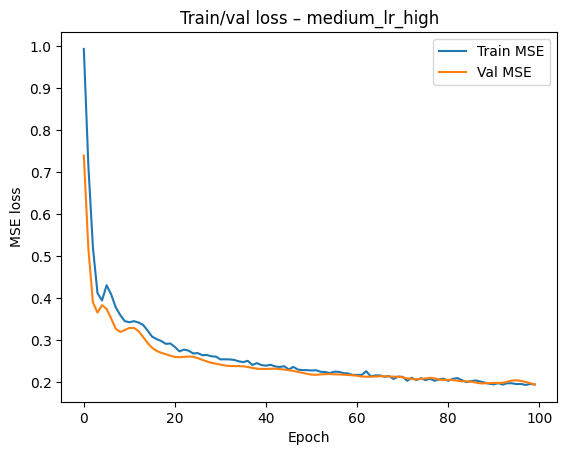

In [9]:
import matplotlib.pyplot as plt

y_pred_test_unscaled = y_scaler.inverse_transform(y_pred_test.reshape(-1, 1))
y_test_unscaled      = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting train/val loss curves for best config
best_name = results_df.sort_values("val_mse").iloc[0]["name"]
print("Best config:", best_name)

train_losses = histories[best_name]["train_losses"]
val_losses   = histories[best_name]["val_losses"]

plt.figure()
plt.plot(train_losses, label="Train MSE")
plt.plot(val_losses,   label="Val MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title(f"Train/val loss – {best_name}")
plt.show()


Best Optuna params: {'data_seed': 611721, 'hidden_dim1': 128, 'hidden_dim2': 208, 'hidden_dim3': 224, 'n_layers': 3, 'dropout': 0.1, 'lr': 0.0020594557496893835}
Using hidden_dims = (128, 208, 224) dropout = 0.1 lr = 0.0020594557496893835


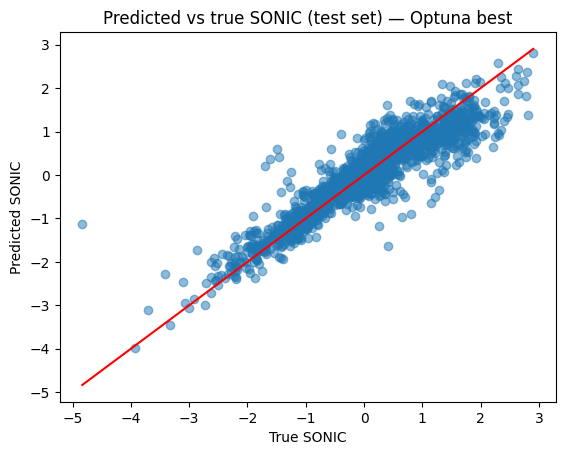

In [10]:
# Use Optuna best trial to rebuild & retrain the model, then plot preds vs true
params = best_trial.params
n_layers = params.get("n_layers", 2)
hidden_dims = tuple([params["hidden_dim1"], params["hidden_dim2"], params["hidden_dim3"]][:n_layers])
dropout = params.get("dropout", 0.0)
lr = params.get("lr", 1e-3)

print("Best Optuna params:", params)
print("Using hidden_dims =", hidden_dims, "dropout =", dropout, "lr =", lr)

# Reproducibility
torch.manual_seed(NP_RANDOM_SEED)
np.random.seed(NP_RANDOM_SEED)

# Build and train model using Optuna params
model = make_model(
    hidden_dims=hidden_dims,
    dropout=dropout,
    activation=nn.ReLU,
)
model, _, _, _ = train_model(
    model,
    X_train, y_train,
    X_val,   y_val,
    lr=lr,
    epochs=100,
    verbose=False,
)

# Predictions on test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).cpu().numpy()
y_true_test = y_test.cpu().numpy()

# Scatter plot
plt.figure()
plt.scatter(y_true_test, y_pred_test, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Optuna best")
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()], color="red")
plt.show()


[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 0: R² = 0.8318
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 1: R² = 0.8413
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 2: R² = 0.8217
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 3: R² = 0.8347
[load_log_data] Using LAS file: /workspaces/project3/datasets/well_data/1_9-7__LOGS.LAS
Removing 0 rows with NaN/inf values
Data shape after NaN removal: X=(12428, 11), y=(12428,)
Seed 4: R² = 0.8461


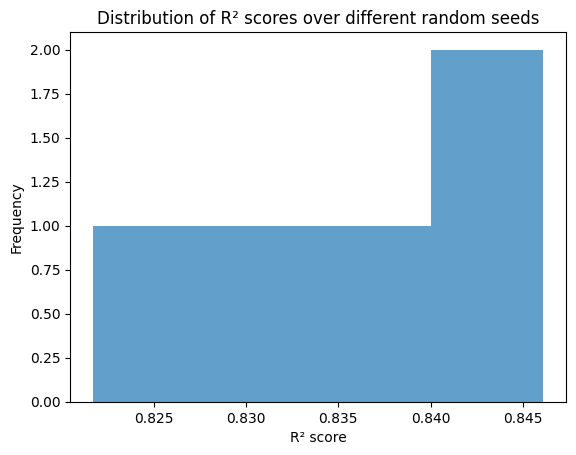

In [11]:
"""
Calculating R² score.
"""

from sklearn.metrics import r2_score

seeds = [0, 1, 2, 3, 4]
scores = []

for seed in seeds:
    # 1. new random split
    (X_train, y_train), (X_val, y_val), (X_test, y_test), x_scaler, y_scaler = load_log_data(None)

    # 2. train model with same hyperparameters
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = make_model(  # use best params fra Optuna
        hidden_dims = hidden_dims,
        dropout = best_dropout,
        activation = nn.ReLU,
    )

    model, best_val_mse, train_losses, val_losses = train_model(
        model,
        X_train, y_train,
        X_val,   y_val,
        lr=best_lr,
        epochs=100,
        verbose=False,
    )

    # 3. evaluate on test
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test)

    r2 = r2_score(
        y_test.numpy().ravel(),
        y_pred_test.numpy().ravel()
    )
    print(f"Seed {seed}: R² = {r2:.4f}")
    scores.append(r2)

print("R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std  R²:", np.std(scores))

plt.figure()
plt.hist(scores, bins='auto', alpha=0.7)
plt.xlabel("R² score")
plt.ylabel("Frequency")
plt.title("Distribution of R² scores over different random seeds")
plt.show()



Ridge baseline:
Test MSE: 0.3135526180267334
Test R²: 0.6768710613250732


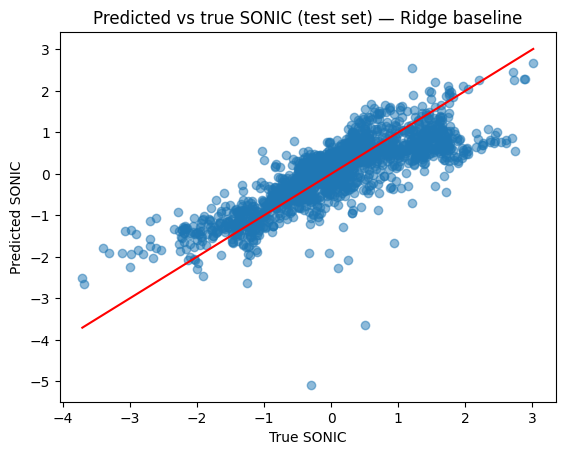

In [12]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Convert tensors to numpy
X_tr = X_train.numpy()
y_tr = y_train.numpy().ravel()
X_te = X_test.numpy()
y_te = y_test.numpy().ravel()

ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)

ridge_pred = ridge.predict(X_te)

ridge_mse = mean_squared_error(y_te, ridge_pred)
ridge_r2  = r2_score(y_te, ridge_pred)

print("Ridge baseline:")
print("Test MSE:", ridge_mse)
print("Test R²:", ridge_r2)

plt.figure()
plt.scatter(y_te, ridge_pred, alpha=0.5)
plt.xlabel("True SONIC")
plt.ylabel("Predicted SONIC")
plt.title("Predicted vs true SONIC (test set) — Ridge baseline")
plt.plot([y_te.min(), y_te.max()],
            [y_te.min(), y_te.max()], color="red")
plt.show()
